In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import subprocess
from tqdm.autonotebook import tqdm
import pandas as pd
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib_venn import venn2
%config InlineBackend.figure_format = 'retina'
import openpyxl

import matplotlib.style
import matplotlib as mpl
# Say, "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.loc'] = "upper left"
mpl.rcParams['figure.facecolor'] = "white"

from lib import parallel_run, geo, misc, seqs, count, gene_ids, align, homer_tools, bedtools, gprofiler, pathway_analysis, homer_logos_table, idr_tools

/tmp/ipykernel_270688/2398916851.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# ATAC

In [6]:
aligned_folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/"
bams = glob.glob(os.path.join(aligned_folder, "*.bam"))
bam_reads = {}
for bam in tqdm(bams):
    res = subprocess.run(f"samtools view -c -F 260 {bam}", stdout=subprocess.PIPE, shell=True)
    bam_reads[bam] = int(res.stdout)

  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
bam_reads

{'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_1.bam': 50423950,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_2.bam': 59218638,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_2.bam': 80103988,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_1.bam': 48045764,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_1.bam': 58790298,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_1.bam': 41959014,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_2.bam': 65174874,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_1.bam': 48435726,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_2.bam': 69848052,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_1.bam': 56510678,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_2.bam': 64491708,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_2.bam': 75833868}

In [4]:
bam_reads = {'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_1.bam': 50423950,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_2.bam': 59218638,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_2.bam': 80103988,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_1.bam': 48045764,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_1.bam': 58790298,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_1.bam': 41959014,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_2.bam': 65174874,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_1.bam': 48435726,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_2.bam': 69848052,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_1.bam': 56510678,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_2.bam': 64491708,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_2.bam': 75833868}

In [45]:
folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/"
sample_info = pd.read_csv(os.path.join(folder, "AAA-StudyInfo.tsv"), sep="\t")
sample_info = sample_info[sample_info.RULA_Run == "FGC2130"]
sample_info.RULA_Lane = sample_info.RULA_Lane.astype(int)

In [12]:
fastq_reads = {}
raw_folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/FGC2130/"
for row in tqdm(sample_info.itertuples(), total=len(sample_info)):
    barcode = row.RULA_Barcode
    sample_name = row.SAMP_name
    lane = row.RULA_Lane
    barcode_with_minus = barcode[:8] + "-" + barcode[8:]
    file_name_1 = os.path.join(raw_folder, f"FGC2130_s_{lane}_1_{barcode_with_minus}.fastq.gz")
    file_name_2 = os.path.join(raw_folder, f"FGC2130_s_{lane}_2_{barcode_with_minus}.fastq.gz")
    target_file_name = os.path.join(aligned_folder, f"{sample_name}_{lane}.bam")
    res1 = subprocess.run(f"zcat {file_name_1} | wc -l", stdout=subprocess.PIPE, shell=True)
    res2 = subprocess.run(f"zcat {file_name_2} | wc -l", stdout=subprocess.PIPE, shell=True)
    fastq_reads[target_file_name] = int(res1.stdout), int(res2.stdout)

  0%|          | 0/12 [00:00<?, ?it/s]

In [13]:
fastq_reads

{'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_1.bam': (112134120,
  112134120),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_2.bam': (149607456,
  149607456),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_1.bam': (114143448,
  114143448),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_2.bam': (149295528,
  149295528),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_1.bam': (126349424,
  126349424),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_2.bam': (167040536,
  167040536),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_1.bam': (114215616,
  114215616),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_2.bam': (155213172,
  155213172),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_1.bam': (131550604,
  131550604),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_2.bam': (176135780,
  176135780),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_1.bam': (93777152,
  93777152),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/al

In [6]:
fastq_reads = {'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_1.bam': (112134120,
  112134120),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_2.bam': (149607456,
  149607456),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_1.bam': (114143448,
  114143448),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_2.bam': (149295528,
  149295528),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_1.bam': (126349424,
  126349424),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_2.bam': (167040536,
  167040536),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_1.bam': (114215616,
  114215616),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_2.bam': (155213172,
  155213172),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_1.bam': (131550604,
  131550604),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_2.bam': (176135780,
  176135780),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_1.bam': (93777152,
  93777152),
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_2.bam': (130289184,
  130289184)}

In [ ]:
raw_folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/FGC2130/"
genome_fasta = "reference/Homo_sapiens.GRCh38.dna.toplevel.fa"
aligned_folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/"

for row in tqdm(sample_info.itertuples(), total=len(sample_info)):
    barcode = row.RULA_Barcode
    sample_name = row.SAMP_name
    lane = row.RULA_Lane
    barcode_with_minus = barcode[:8] + "-" + barcode[8:]
    file_name_1 = os.path.join(raw_folder, f"FGC2130_s_{lane}_1_{barcode_with_minus}.fastq.gz")
    file_name_2 = os.path.join(raw_folder, f"FGC2130_s_{lane}_2_{barcode_with_minus}.fastq.gz")
    target_file_name = os.path.join(aligned_folder, f"{sample_name}_{lane}.bam")
    runner = parallel_run.LocalRunner(os.path.join("logs", f"bowtie_align_{sample_name}_{lane}.log"), threads=40)
    align.align_chipseq([file_name_1, file_name_2], os.path.join(aligned_folder, "qc_tmp"), genome_fasta, runner, 40, unique_only=False)
    runner.run()

In [62]:
pbc1_data = pd.read_csv("data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/qc_tmp/pbc1.tsv", sep="\t", header=None)
pbc1_data = pbc1_data.set_index(0).to_dict()[1]

aligned_folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/"
pbc1_data1 = {}
for row in tqdm(sample_info.itertuples(), total=len(sample_info)):
    barcode = row.RULA_Barcode
    sample_name = row.SAMP_name
    lane = row.RULA_Lane
    barcode_with_minus = barcode[:8] + "-" + barcode[8:]
    file_name_tmp = os.path.join(aligned_folder, "qc_tmp", f"FGC2130_s_{lane}_1_{barcode_with_minus}.unique1.bam")
    target_file_name = os.path.join(aligned_folder, f"{sample_name}_{lane}.bam")
    pbc1_data1[target_file_name] = pbc1_data[file_name_tmp.replace("qc_tmp/", "qc_tmp//")]

  0%|          | 0/12 [00:00<?, ?it/s]

In [63]:
pbc1_data1

{'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_1.bam': 0.838883802239964,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_2.bam': 0.718493442301117,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_1.bam': 0.840022220003657,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_2.bam': 0.72426781168118,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_1.bam': 0.887892728704939,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_2.bam': 0.763990255568559,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_1.bam': 0.898968054756629,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_2.bam': 0.779214114855421,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_1.bam': 0.890831086183761,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_2.bam': 0.770554028163704,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_1.bam': 0.905038175880147,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_2.bam': 0.790865164771515}

In [8]:
pbc1_data1 = {'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_1.bam': 0.838883802239964,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_2.bam': 0.718493442301117,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_1.bam': 0.840022220003657,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_2.bam': 0.72426781168118,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_1.bam': 0.887892728704939,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_2.bam': 0.763990255568559,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_1.bam': 0.898968054756629,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_2.bam': 0.779214114855421,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_1.bam': 0.890831086183761,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_2.bam': 0.770554028163704,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_1.bam': 0.905038175880147,
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_2.bam': 0.790865164771515}

In [ ]:
aligned_folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/"
nrf_data = {}
for row in tqdm(sample_info.itertuples(), total=len(sample_info)):
    barcode = row.RULA_Barcode
    sample_name = row.SAMP_name
    lane = row.RULA_Lane
    barcode_with_minus = barcode[:8] + "-" + barcode[8:]
    file_name_tmp = os.path.join(aligned_folder, "qc_tmp", f"FGC2130_s_{lane}_1_{barcode_with_minus}.unique1.bam")
    target_file_name = os.path.join(aligned_folder, f"{sample_name}_{lane}.bam")
    num_reads_total = align.num_reads_in_bam(file_name_tmp)
    num_unique_reads = int(parallel_run.capture_stdout(f"samtools rmdup {file_name_tmp} - | samtools view -c -f 3 -"))
    nrf = num_unique_reads / num_reads_total
    nrf_data[target_file_name] = nrf
    print(target_file_name, nrf)

In [9]:
alignment_rates = {}
aligned_folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/"
for row in tqdm(sample_info.itertuples(), total=len(sample_info)):
    barcode = row.RULA_Barcode
    sample_name = row.SAMP_name
    lane = row.RULA_Lane
    barcode_with_minus = barcode[:8] + "-" + barcode[8:]
    log_file = os.path.join("logs", f"bowtie_align_{sample_name}_{lane}.log")
    with open(log_file, "r") as f:
        lines = f.readlines()
    
    alignment_lines = [l for l in lines if "overall alignment rate" in l]
    alignment_percent = alignment_lines[-1].split(" ")[0]
    target_file_name = os.path.join(aligned_folder, f"{sample_name}_{lane}.bam")
    alignment_rates[target_file_name] = alignment_percent

  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
alignment_rates

{'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_1.bam': '94.04%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_2.bam': '94.70%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_1.bam': '93.70%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_2.bam': '94.37%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_1.bam': '95.40%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_2.bam': '96.05%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_1.bam': '94.78%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_2.bam': '95.60%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_1.bam': '95.15%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_2.bam': '95.93%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_1.bam': '94.94%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_2.bam': '95.66%'}

In [6]:
alignment_rates = {'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_1.bam': '94.04%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont1_ATAC_v2_2.bam': '94.70%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_1.bam': '93.70%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/Cont2_ATAC_v2_2.bam': '94.37%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_1.bam': '95.40%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-1_ATAC_v2_2.bam': '96.05%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_1.bam': '94.78%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO1-2_ATAC_v2_2.bam': '95.60%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_1.bam': '95.15%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-1_ATAC_v2_2.bam': '95.93%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_1.bam': '94.94%',
 'data/ATAC-Seq/hiPSCCM-ERRagKO/aligned/KO6-2_ATAC_v2_2.bam': '95.66%'}

In [9]:
reads_info = []
for sample_bam in bam_reads:
    sample_name = os.path.basename(sample_bam.replace("_ATAC_v2", "").replace(".bam", ""))
    reads_info.append({"sample name": sample_name, "aligned fragments": bam_reads[sample_bam], "alignment rate": alignment_rates[sample_bam],
                      "PBC1": pbc1_data1[sample_bam], "NRF": nrf_data[sample_bam]})
    
reads_info = pd.DataFrame.from_records(reads_info)
reads_info = reads_info.sort_values("sample name")
reads_info

NameError: name 'nrf_data' is not defined

In [11]:
rep_names = set()
for sample_bam in bam_reads:
    name = os.path.basename(sample_bam.replace("_ATAC_v2", "").replace(".bam", ""))
    rep_names.add(name.split("_")[0])

In [22]:
for rep_name in rep_names:
    tags = f"data/ATAC-Seq/hiPSCCM-ERRagKO/tags/{rep_name}_ATAC_v2.tags/"
    peaks_file = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{rep_name}_QC.peaks"
    runner = parallel_run.LocalRunner(os.path.join("logs", f"atac_peaks_{rep_name}.log"), threads=15)    
    homer_tools.find_peaks(tags, peaks_file, runner, peak_size=75, min_dist_between_peaks=75, tags_to_define_peak=6)
    runner.run(wait=False)

Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6-1_ATAC_v2.tags/' -size 75    -minDist 75 -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO6-1_QC.peaks'   -tagThreshold 6    && echo Finished successfully ; } >> 'logs/atac_peaks_KO6-1.log' 2>&1
Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-2_ATAC_v2.tags/' -size 75    -minDist 75 -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO1-2_QC.peaks'   -tagThreshold 6    && echo Finished successfully ; } >> 'logs/atac_peaks_KO1-2.log' 2>&1
Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_ATAC_v2.tags/' -size 75    -minDist 75 -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont1_QC.peaks'   -tagThreshold 6    && echo Finished successfully ; } >> 'logs/atac_peaks_Cont1.log' 2>&1
Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_ATAC_v2.tags/' -si

In [41]:
for rep_name in rep_names:
    for tech_rep in [1, 2]:
        tags = f"data/ATAC-Seq/hiPSCCM-ERRagKO/tags/{rep_name}_ATAC_v2_{tech_rep}.tags/"
        peaks_file = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{rep_name}_{tech_rep}_QC.peaks"
        runner = parallel_run.LocalRunner(os.path.join("logs", f"atac_peaks_{rep_name}_{tech_rep}.log"), threads=15)    
        homer_tools.find_peaks(tags, peaks_file, runner, peak_size=75, min_dist_between_peaks=75, tags_to_define_peak=5)
        runner.run(wait=False)

Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6-1_ATAC_v2_1.tags/' -size 75    -minDist 75 -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO6-1_1_QC.peaks'   -tagThreshold 5    && echo Finished successfully ; } >> 'logs/atac_peaks_KO6-1_1.log' 2>&1
Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6-1_ATAC_v2_2.tags/' -size 75    -minDist 75 -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO6-1_2_QC.peaks'   -tagThreshold 5    && echo Finished successfully ; } >> 'logs/atac_peaks_KO6-1_2.log' 2>&1
Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-2_ATAC_v2_1.tags/' -size 75    -minDist 75 -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO1-2_1_QC.peaks'   -tagThreshold 5    && echo Finished successfully ; } >> 'logs/atac_peaks_KO1-2_1.log' 2>&1
Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-2_

In [21]:
for rep_name in rep_names:
    for pseudo_rep in [1, 2]:
        tags = f"data/ATAC-Seq/hiPSCCM-ERRagKO/tags/{rep_name}_QC_pseudo{pseudo_rep}.tags/"
        peaks_file = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{rep_name}_p{pseudo_rep}_QC.peaks"
        runner = parallel_run.LocalRunner(os.path.join("logs", f"atac_peaks_{rep_name}_p{pseudo_rep}.log"), threads=15)    
        homer_tools.find_peaks(tags, peaks_file, runner, peak_size=75, min_dist_between_peaks=75, tags_to_define_peak=5)
        runner.run(wait=False)

Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_QC_pseudo1.tags/' -size 75    -minDist 75 -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont1_p1_QC.peaks'   -tagThreshold 5    && echo Finished successfully ; } >> 'logs/atac_peaks_Cont1_p1.log' 2>&1
Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_QC_pseudo2.tags/' -size 75    -minDist 75 -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont1_p2_QC.peaks'   -tagThreshold 5    && echo Finished successfully ; } >> 'logs/atac_peaks_Cont1_p2.log' 2>&1
Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-1_QC_pseudo1.tags/' -size 75    -minDist 75 -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO1-1_p1_QC.peaks'   -tagThreshold 5    && echo Finished successfully ; } >> 'logs/atac_peaks_KO1-1_p1.log' 2>&1
Running the following command sequence in parallel:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/ta

In [26]:
rep_peak_counts = {}
for rep_name in rep_names:
    peaks_file = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{rep_name}_QC.peaks"
    with open(peaks_file, "r") as f:
        lines = f.readlines(1000)
    
    count_line = [l for l in lines if l.startswith("# total peaks =")][0]
    rep_peak_counts[rep_name] = int(count_line.strip().split(" ")[-1])

In [24]:
rep_peak_counts

{'KO6-1': 105555,
 'KO1-2': 100957,
 'Cont1': 141468,
 'Cont2': 139413,
 'KO1-1': 109500,
 'KO6-2': 87959}

In [12]:
for sample in ["Cont", "KO1-", "KO6-"]:
    for rep in [1, 2]:
        rep_td = f"data/ATAC-Seq/hiPSCCM-ERRagKO/tags/{sample}{rep}_ATAC_v2.tags/"
        pseudos = [f"data/ATAC-Seq/hiPSCCM-ERRagKO/tags/{sample}{rep}_QC_pseudo{pse}.tags" for pse in [1, 2]]
        for td in pseudos:
            if os.path.exists(td):
                shutil.rmtree(td)
            
        homer_tools.pseudoreplicate(rep_td, *pseudos)

Running command w/120 threads: makeTagDirectory 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_QC_pseudo1.tags' -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_QC_pseudo1.tags.tmp' -keepAll -single
Running command w/120 threads: makeTagDirectory 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_QC_pseudo2.tags' -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_QC_pseudo2.tags.tmp' -keepAll -single
Running command w/120 threads: makeTagDirectory 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_QC_pseudo1.tags' -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_QC_pseudo1.tags.tmp' -keepAll -single
Running command w/120 threads: makeTagDirectory 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_QC_pseudo2.tags' -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_QC_pseudo2.tags.tmp' -keepAll -single
Running command w/120 threads: makeTagDirectory 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-1_QC_pseudo1.tags' -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-1_QC_pseudo1.tags.tmp' -keepAll -single
Running command w/120 threads: makeTagDirectory 'd

In [31]:
qc_pics_folder = "pics/atac/QC"
misc.make_sure_folder_exists(qc_pics_folder)

runs = []
for rep_name in rep_names:
    pseudo_peaks = [f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{rep_name}_p{pseudo_rep}_QC.peaks" for pseudo_rep in [1, 2]]
    runner = parallel_run.LocalRunner(os.path.join("logs", f"atac_idr_{rep_name}_pseudo.log"), threads=15)
    idr_out = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{rep_name}_pseudo_QC.idr"
    pic = os.path.join(qc_pics_folder, f"{rep_name}_pseudo_QC.idr.png")
    idr.idr_analysis(*pseudo_peaks, output_file=idr_out, plot_output=pic, runner=runner)
    runs.append(runner.run(wait=False))
    
for p in runs:
    p.wait()

Running the following command sequence in parallel:
{ idr --samples 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont1_p1_QC.narrowPeak' 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont1_p2_QC.narrowPeak' -o data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont1_pseudo_QC.idr --plot && mv 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont1_pseudo_QC.idr.png' 'pics/atac/QC/Cont1_pseudo_QC.idr.png' && echo Finished successfully ; } >> 'logs/atac_idr_Cont1_pseudo.log' 2>&1
Running the following command sequence in parallel:
{ idr --samples 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO1-1_p1_QC.narrowPeak' 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO1-1_p2_QC.narrowPeak' -o data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO1-1_pseudo_QC.idr --plot && mv 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO1-1_pseudo_QC.idr.png' 'pics/atac/QC/KO1-1_pseudo_QC.idr.png' && echo Finished successfully ; } >> 'logs/atac_idr_KO1-1_pseudo.log' 2>&1
Running the following command sequence in parallel:
{ idr --samples 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/KO1-2_p1_QC.narrowP

In [ ]:
qc_pics_folder = "pics/atac/QC"
misc.make_sure_folder_exists(qc_pics_folder)

runs = []
for rep_name in rep_names:
    pseudo_peaks = [f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{rep_name}_p{pseudo_rep}_QC.peaks" for pseudo_rep in [1, 2]]
    pic = os.path.join(qc_pics_folder, f"{rep_name}_pseudo_QC.idr.pdf")
    narrowpeaks = [misc.replace_extension(p, "narrowPeak") for p in pseudo_peaks]
    idr_tools.idr_plot(narrowpeaks, pic)

In [15]:
qc_pics_folder = "pics/atac/QC"
runs = []
for sample in ["Cont", "KO1-", "KO6-"]:
    rep_peaks = [f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample}{rep}_QC.peaks" for rep in [1, 2]]
    idr_out = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample}_QC.idr"
    pic = os.path.join(qc_pics_folder, f"{sample}_reps_QC.idr.png")    
    runs.append(parallel_run.start(lambda: idr.idr_analysis(*rep_peaks, output_file=idr_out, plot_output=pic), f"logs/atac_idr_{sample}_reps.log"))
    
for p in runs:
    p.join()

In [16]:
qc_pics_folder = "pics/atac/QC"
runs = []
for sample in ["Cont", "KO1-", "KO6-"]:
    rep_peaks = [f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample}{rep}_QC.peaks" for rep in [1, 2]]
    idr_out = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample}_QC.idr"
    pic = os.path.join(qc_pics_folder, f"{sample}_reps_QC.idr.pdf")   
    narrowpeaks = [misc.replace_extension(p, "narrowPeak") for p in rep_peaks]
    parallel_run.start(lambda: idr_tools.idr_plot(narrowpeaks, pic))

Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.69 1.42 0.89 0.75]
Final parameter values: [2.04 1.57 0.94 0.76]
Final parameter values: [2.17 1.62 0.94 0.78]


In [21]:
runs = []
for sample in ["Cont", "KO1", "KO6"]:
    tags = f"data/ATAC-Seq/hiPSCCM-ERRagKO/tags/{sample}.tags"
    idr_out = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample}_pooled_pseudo_QC.idr"
    pic = os.path.join(qc_pics_folder, f"{sample}_pooled_pseudo_QC.idr.png")
    peak_calling_params = {"peak_size": 75, "min_dist_between_peaks": 75, "tags_to_define_peak": 5}
    log_file = f"logs/atac_idr_{sample}_pooled_pseudo.log"
    runs.append(parallel_run.start(lambda: idr.pseudo_idr(tags, "data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/",
                                                          output_file=idr_out, plot_output=pic, peak_calling_params=peak_calling_params), 
                                   log_file))

parallel_run.wait_all(runs)

In [39]:
def idr_peaks(idr_file, cutoff):
    data = pd.read_csv(idr_file, sep="\t", header=None)
    log_idr = data[11]
    idr = 10 ** (-log_idr)
    return sum(idr < cutoff)

def num_peaks(peaks_file):
    data = pd.read_csv(peaks_file, sep="\t", header=None, comment="#")
    return len(data)

In [77]:
cutoff = 0.05
sample_qc = reads_info.copy().set_index("sample name")
sample_qc["Replicate peaks"] = np.nan
sample_qc["IDR peaks"] = np.nan
sample_qc["IDR: Self consistency ratio"] = np.nan
sample_qc["IDR: Rescue ratio"] = np.nan
for sample in ["Cont", "KO1-", "KO6-"]:
    Nt = idr_peaks(f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample}_QC.idr", cutoff)
    N1, N2 = [idr_peaks(f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample}{rep}_pseudo_QC.idr", cutoff) for rep in [1, 2]]
    Np = idr_peaks(f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample.replace('-', '')}_pooled_pseudo_QC.idr", cutoff)
    self_consistency = max(N1, N2) / min(N1, N2)
    rescue = max(Np, Nt) / min(Np, Nt)
    print(f"{sample}: Nt = {Nt}, N1 = {N1}, N2 = {N2}, Np = {Np}, self consistency ratio: {self_consistency}, "
          f"rescue ratio: {rescue}")
    
    for rep in [1, 2]:
        sample_qc.loc[f"{sample}{rep}_1", "Replicate peaks"] = num_peaks(f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample}{rep}_QC.peaks")
    
    sample_qc.loc[f"{sample}1_1", "IDR peaks"] = Nt
    sample_qc.loc[f"{sample}1_1", "IDR: Self consistency ratio"] = self_consistency
    sample_qc.loc[f"{sample}1_1", "IDR: Rescue ratio"] = rescue
    
print(sample_qc)

Cont: Nt = 38350, N1 = 27121, N2 = 27663, Np = 48809, self consistency ratio: 1.0199845138453596, rescue ratio: 1.2727249022164275
KO1-: Nt = 41276, N1 = 32229, N2 = 30036, Np = 47943, self consistency ratio: 1.0730123851378346, rescue ratio: 1.1615224343444133
KO6-: Nt = 39577, N1 = 33106, N2 = 27717, Np = 45323, self consistency ratio: 1.1944294115524767, rescue ratio: 1.1451853349167447
             aligned fragments alignment rate      PBC1       NRF  \
sample name                                                         
Cont1_1               48045764         94.04%  0.838884  0.452921   
Cont1_2               65174874         94.70%  0.718493  0.402410   
Cont2_1               48435726         93.70%  0.840022  0.449160   
Cont2_2               64491708         94.37%  0.724268  0.402348   
KO1-1_1               56510678         95.40%  0.887893  0.513959   
KO1-1_2               75833868         96.05%  0.763990  0.457143   
KO1-2_1               50423950         94.78%  0.898968

In [79]:
sample_qc["FRIP"] = np.nan
for sample in ["Cont", "KO1-", "KO6-"]:
    for rep in [1, 2]:
        peaks_file = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{sample}{rep}_QC.peaks"
        total_tags = None
        total_tags_in_peaks = None
        with open(peaks_file, "r") as f:
            while total_tags is None or total_tags_in_peaks is None:
                l = f.readline().strip()
                if "Total tags = " in l:
                    total_tags = float(l.split(" ")[-1])
                elif "Total tags in peaks = " in l:
                    total_tags_in_peaks = float(l.split(" ")[-1])
        
        sample_qc.loc[f"{sample}{rep}_1", "FRIP"] = total_tags_in_peaks / total_tags
        
print(sample_qc)
sample_qc.to_excel("tables/atac_qc.xlsx", sheet_name="QC summary")

             aligned fragments alignment rate      PBC1       NRF  \
sample name                                                         
Cont1_1               48045764         94.04%  0.838884  0.452921   
Cont1_2               65174874         94.70%  0.718493  0.402410   
Cont2_1               48435726         93.70%  0.840022  0.449160   
Cont2_2               64491708         94.37%  0.724268  0.402348   
KO1-1_1               56510678         95.40%  0.887893  0.513959   
KO1-1_2               75833868         96.05%  0.763990  0.457143   
KO1-2_1               50423950         94.78%  0.898968  0.536903   
KO1-2_2               69848052         95.60%  0.779214  0.479890   
KO6-1_1               58790298         95.15%  0.890831  0.554557   
KO6-1_2               80103988         95.93%  0.770554  0.493807   
KO6-2_1               41959014         94.94%  0.905038  0.603678   
KO6-2_2               59218638         95.66%  0.790865  0.541079   

             Replicate peaks  IDR

In [52]:
tss_regions = "data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/tss_4k.peaks"
homer_tools.make_tss_peaks("hg38", 4200, tss_regions)
tss_regions_schrom = "data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/tss_4k.schrom.peaks"
homer_tools.to_short_chromnames(tss_regions, tss_regions_schrom)

Running command w/120 threads: annotatePeaks.pl tss hg38 -size 4200  > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/tss_4k.peaks'


Running command w/120 threads: annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/tss_4k.schrom.peaks' none -size 4600 -hist 10 -ghist -cpu 120  -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont.tags/' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1.tags/' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6.tags/' > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/tss_4k.schrom.peaks.counts'


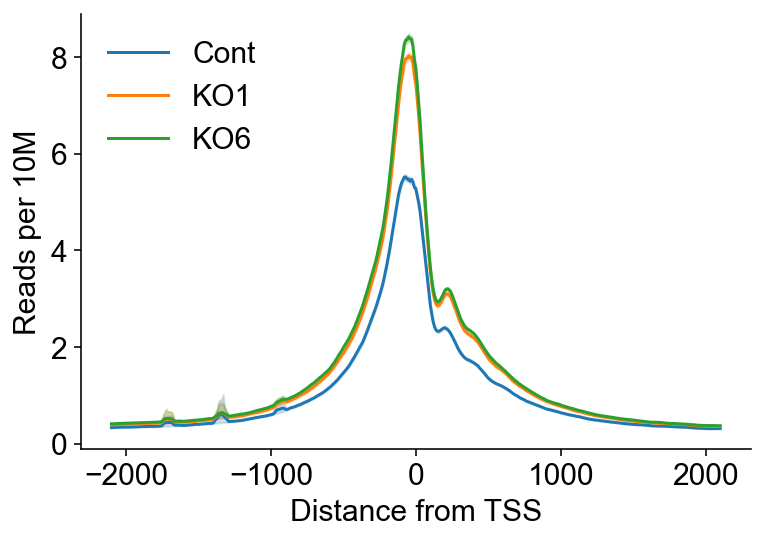

In [ ]:
tss_regions_schrom = "data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/tss_4k.schrom.peaks"
homer_tools.peak_average_density_plot(tss_regions_schrom, 
                                      {sample: f"data/ATAC-Seq/hiPSCCM-ERRagKO/tags/{sample}.tags/" for sample in ["Cont", "KO1", "KO6"]}, 
                                      size=4200)

plt.xlabel("Distance from TSS")
#plt.savefig("pics/atac/TSS_enrichment.png", dpi=300)
plt.savefig("pics/atac/QC/TSS_enrichment.pdf")

# RNA-Seq

In [6]:
xlr = pd.ExcelWriter('tables/rna-seq_qc.xlsx')
pd.read_csv("data/RNA-Seq/ERRag_KO_hiPSC-CM/counts/summary.tsv", sep="\t").to_excel(xlr, "KO alignment summary", index=False)
pd.read_csv("data/RNA-Seq/RNA-seq in OE ERRg iPSC-CM/counts/summary.tsv", sep="\t").to_excel(xlr, "OE alignment summary", index=False)
xlr.save()

In [47]:
fpkm_data = pd.read_excel("tables/ERRg_OE_DE.xlsx", sheet_name="FPKM")

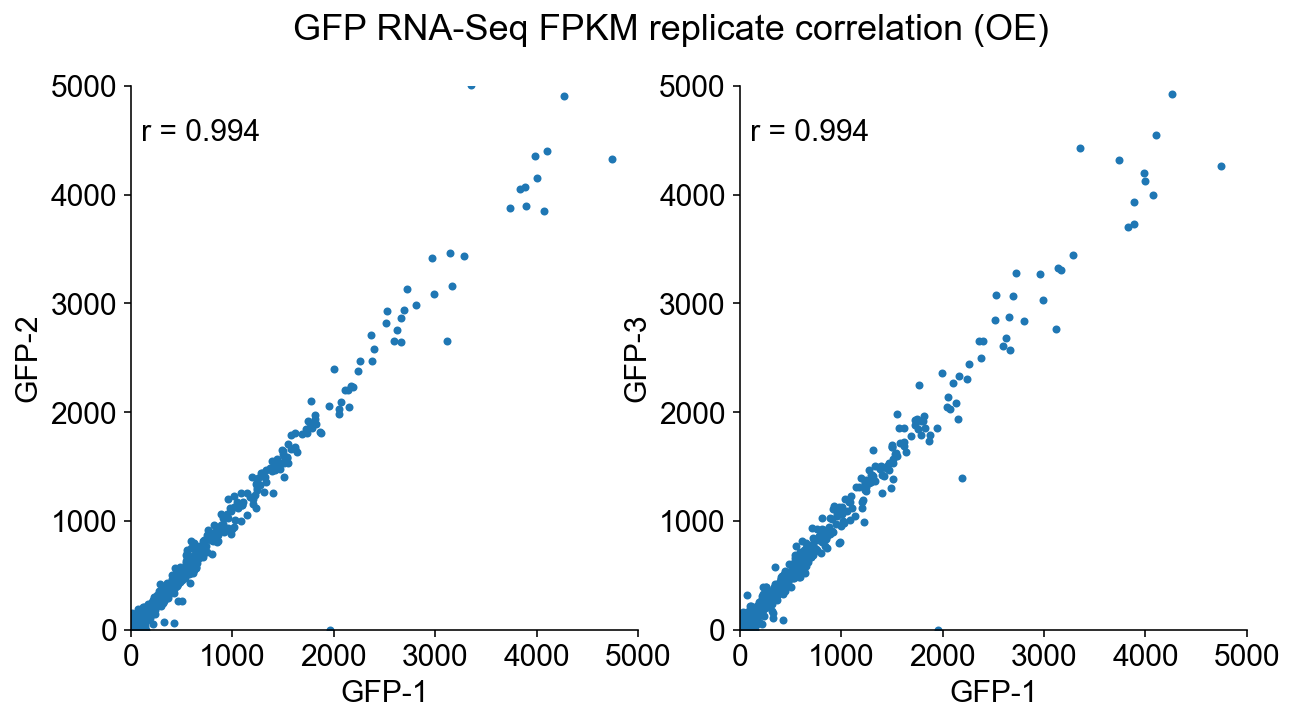

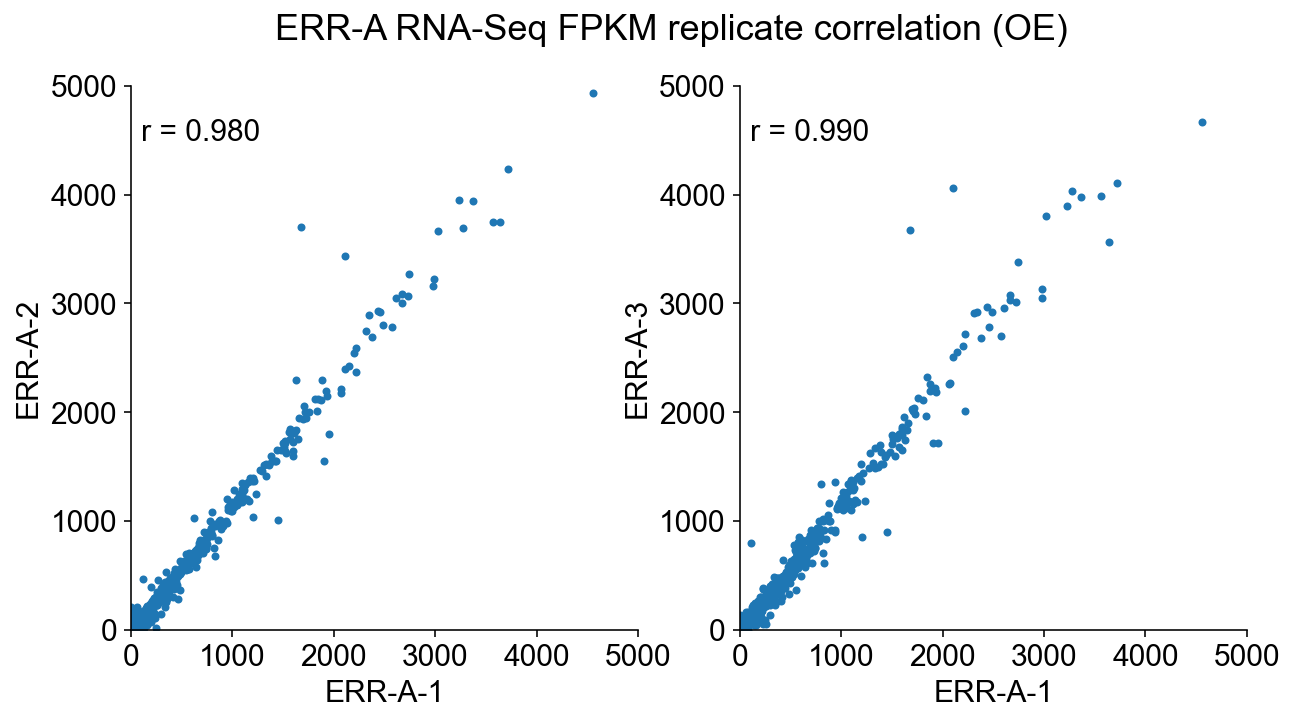

In [48]:
rnaseq_qc_folder = "pics/RNA-Seq/QC"
misc.make_sure_folder_exists(rnaseq_qc_folder)

for dataset in ["GFP", "ERR-A"]:
    fig = plt.figure(figsize=[10, 5])
    gs = GridSpec(1, 2)
    for i, (xi, yi) in enumerate([[1, 2], [1, 3]]):
        ax = fig.add_subplot(gs[i])
        x, y = [(fpkm_data[f"{dataset}-{i}"]) for i in [xi, yi]]
        ax.scatter(x, y, marker='.')
        plt.xlim([0, 5000])
        plt.ylim([0, 5000])
        plt.xlabel(f"{dataset}-{xi}")
        plt.ylabel(f"{dataset}-{yi}")
        corr = np.corrcoef(x, y)[0, 1]
        plt.text(100, 4500, f"r = {corr:.3f}")
    
    plt.suptitle(f"{dataset} RNA-Seq FPKM replicate correlation (OE)")
        
    plt.savefig(os.path.join(rnaseq_qc_folder, f"{dataset}_OE_correlation.png"), dpi=300)

In [52]:
fpkm_data = pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name="FPKM")

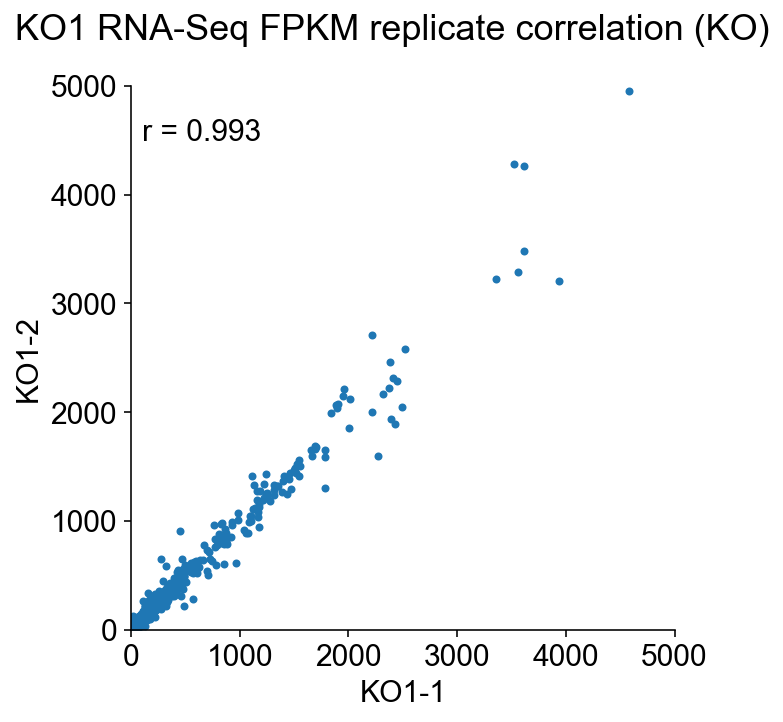

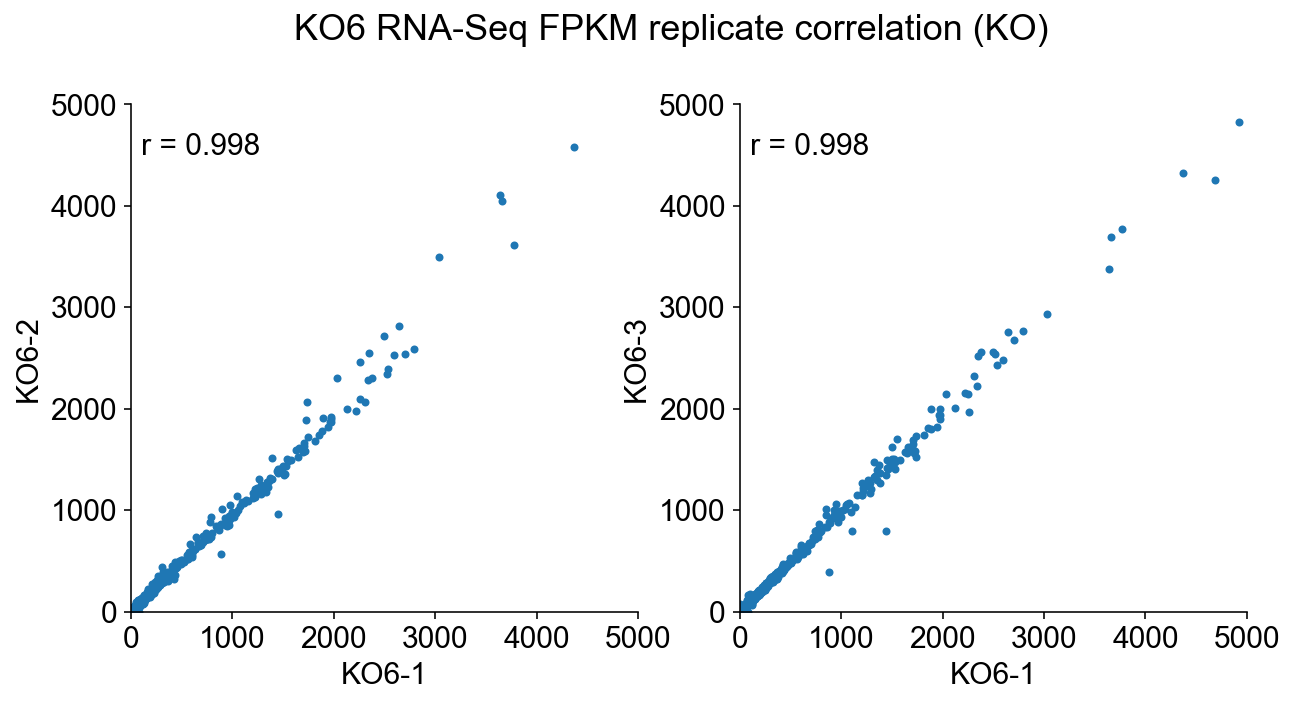

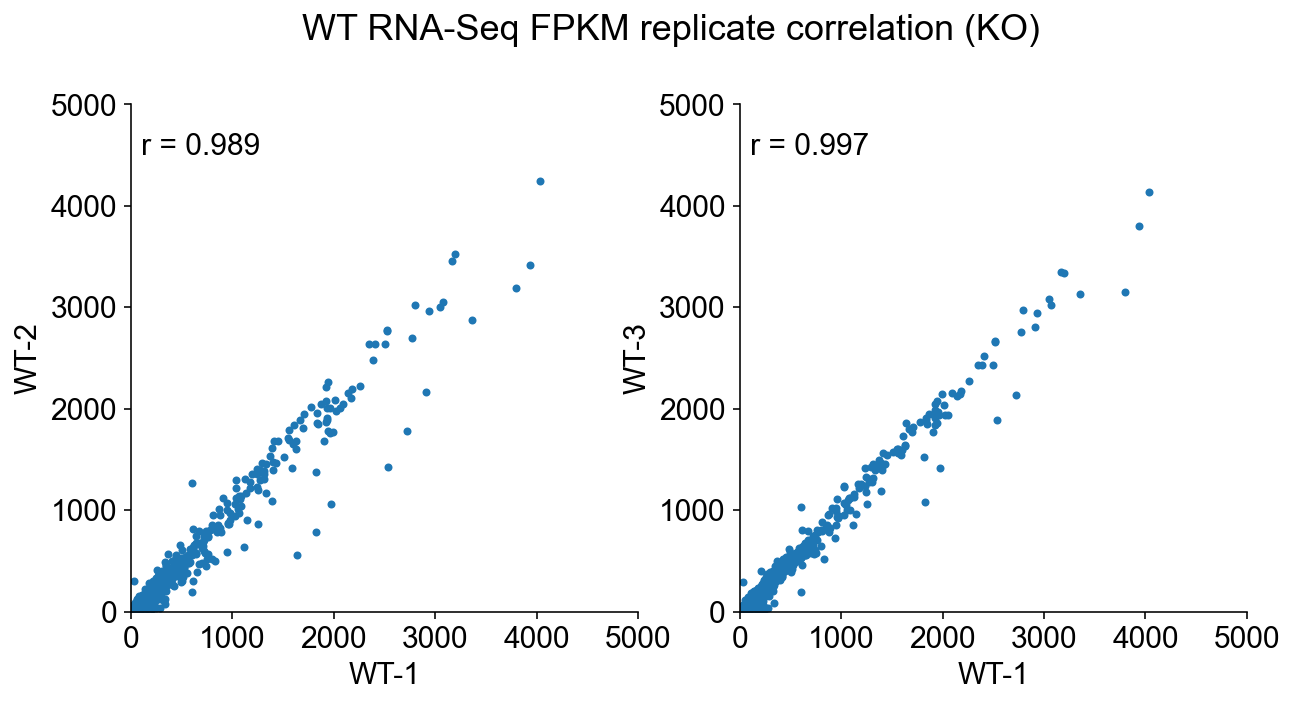

In [61]:
rnaseq_qc_folder = "pics/RNA-Seq/QC"
misc.make_sure_folder_exists(rnaseq_qc_folder)

for dataset in ["KO1", "KO6", "WT"]:
    fig = plt.figure(figsize=[10 if dataset != "KO1" else 6, 5])
    gs = GridSpec(1, 2)
    for i, (xi, yi) in enumerate([[1, 2], [1, 3]]):           
        if dataset != "KO1":
            ax = fig.add_subplot(gs[i])
        elif i == 1:
            continue
            
        x, y = [(fpkm_data[f"{dataset}_{i}"]) for i in [xi, yi]]
        plt.scatter(x, y, marker='.')
        plt.xlim([0, 5000])
        plt.ylim([0, 5000])
        plt.xlabel(f"{dataset}-{xi}")
        plt.ylabel(f"{dataset}-{yi}")
        corr = np.corrcoef(x, y)[0, 1]
        plt.text(100, 4500, f"r = {corr:.3f}")
        plt.gca().set_aspect('equal', adjustable='box')
    
    plt.suptitle(f"{dataset} RNA-Seq FPKM replicate correlation (KO)")
        
    plt.savefig(os.path.join(rnaseq_qc_folder, f"{dataset}_KO_correlation.png"), dpi=300)

In [51]:
fpkm_data.columns

Index(['gene_name', 'gene_id', 'ERR-A-1', 'ERR-A-2', 'ERR-A-3', 'GFP-1',
       'GFP-2', 'GFP-3', 'outlier', 'ERR vs. GFP log2FoldChange',
       'ERR vs. GFP padj'],
      dtype='object')

# Peak counts

In [41]:
peak_count_data = {}

def line_count(file):
    return int(parallel_run.capture_stdout(f"grep -c '^[^#]' {misc.join_quoted_paths(file)}").split(b" ")[0])   

for dataset in ["Cont", "KO1", "KO6"]:
    peak_count_data[f"ATAC-Seq {dataset.replace('-', '')}"] = \
        line_count(f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{dataset}_intersection.peaks")
    
peak_count_data["ChIP-Seq ERRg"] = \
    line_count("data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks")

peak_count_data["ChIP-Seq H3K27Ac WT"] =\
    line_count("data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks")

peak_count_data["ChIP-Seq H3K27Ac KO"] =\
    line_count("data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_KO_vas_Input_pooled.peaks")

peak_count_data["ChIP-Seq GATA4"] = \
    line_count("data/ChIP-Seq/gata4/peaks/gata4_pooled.peaks")

peak_count_data["ChIP-Seq GATA6"] = \
    line_count("data/ChIP-Seq/gata6/peaks/gata6_hg38.peaks")

peak_count_data = [{"Experiment": k.split(" ")[0], "Dataset": " ".join(k.split(" ")[1:]), "Peak count": v} 
                   for k, v in peak_count_data.items()]

peak_count_data = pd.DataFrame.from_records(peak_count_data)
peak_count_data.to_excel("tables/peak_counts.xlsx", sheet_name="Peak counts", index=False)

# ChIP-Seq: H3K27ac

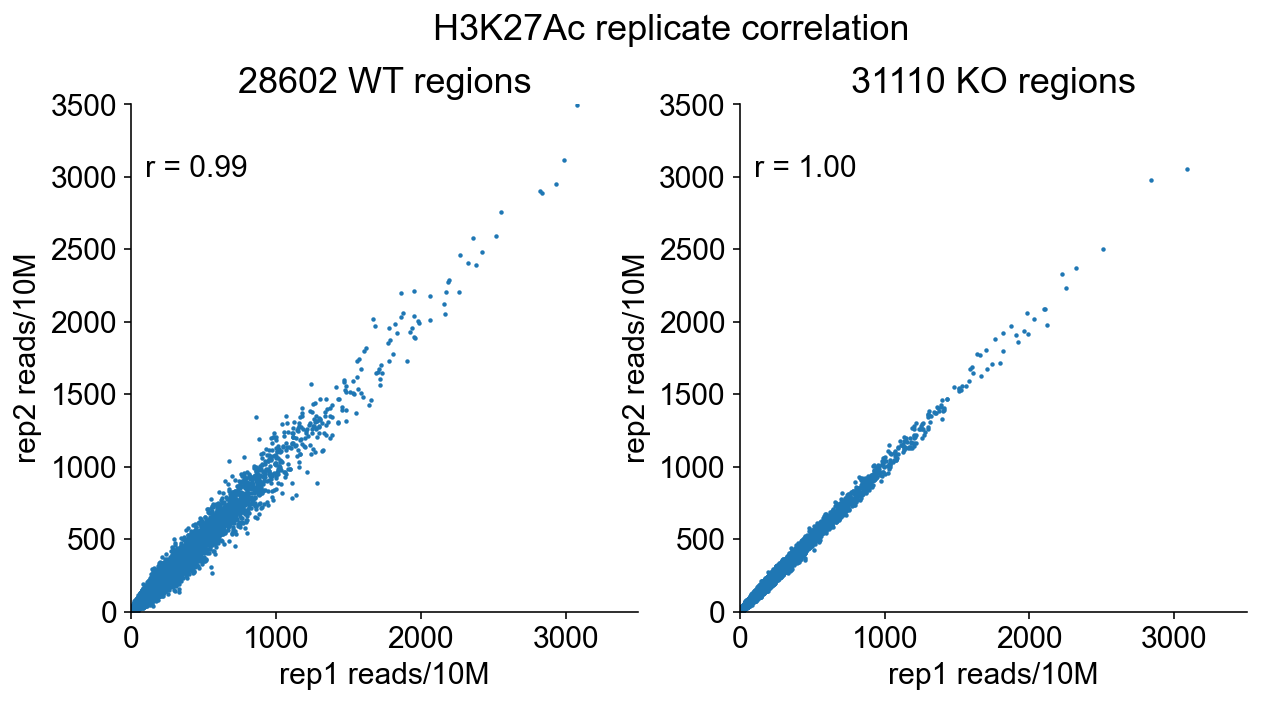

In [29]:
fig = plt.figure(figsize=[10, 5])
gs = GridSpec(1, 2)

for i, dataset in enumerate(["WT", "KO"]):
    ax = fig.add_subplot(gs[i])
    num_peaks, r = homer_tools.reads_scatterplot(f"data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_{dataset}_vs_Input_pooled.peaks", 
                                                 *[f"data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-{dataset}-{r}.tags" 
                                                   for r in [1, 2]], "rep1 reads/10M", "rep2 reads/10M", 
                                                 log_scale=False, size="given", recount=False)

    ax.axis("square")
    ax.set_xlim([0, 3500])
    ax.set_ylim([0, 3500])
    plt.title(f"{num_peaks} {dataset} regions")
    plt.text(100, 3000, f"r = {r:0.2f}")
    
plt.suptitle("H3K27Ac replicate correlation")
misc.make_sure_folder_exists("pics/H3K27ac_QC")
plt.savefig("pics/H3K27ac_QC/replicates_correlation.png", dpi=300)

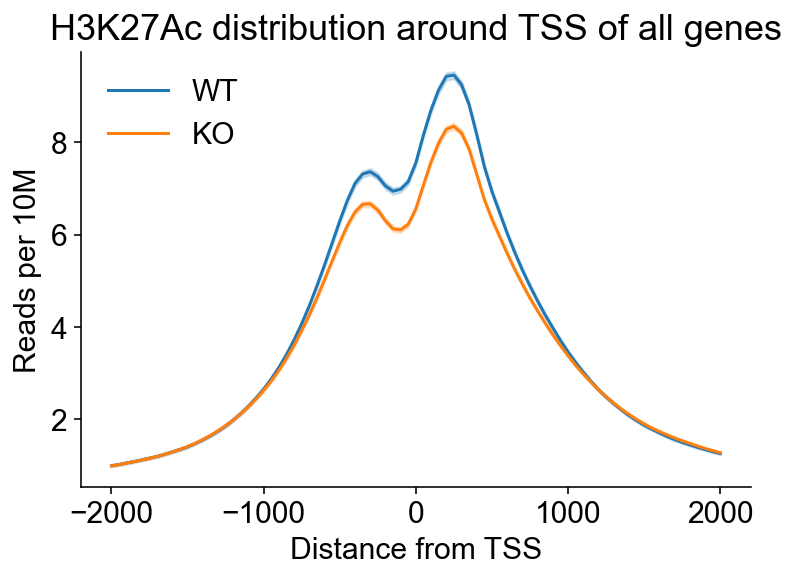

In [6]:
tss_peaks = "data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/tss_4k.schrom.peaks"
tags_sets = {dataset: f"data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-{dataset}.tags" for dataset in ["WT", "KO"]}
homer_tools.peak_average_density_plot(tss_peaks, tags_sets, size=4000, bin_size=50, recount=False)
plt.xlabel("Distance from TSS")
plt.title("H3K27Ac distribution around TSS of all genes")
#plt.savefig("pics/H3K27ac_QC/TSS_distribution.png", dpi=300)
plt.savefig("pics/H3K27ac_QC/TSS_distribution.pdf")